In [1]:
# Imports:
import pandas as pd
import geopandas as gpd
from osgeo import osr, gdal
import matplotlib.pyplot as plt
import numpy as np
import georasters as gr
import seaborn as sns
sns.set_theme(style="darkgrid")
from scipy.interpolate import griddata
import rasterio
import pyproj
from rasterio.plot import show
from scipy.interpolate import griddata
import copy
import collections
import math
import pgmpy.models
import pgmpy.inference
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import ParameterEstimator
from pgmpy.inference import VariableElimination
import networkx as nx

/opt/anaconda3/envs/SLResearch/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Read Files/ Load Data:
vlm_df = pd.read_excel('Data/data_analisis.xls')

elevation_file = gr.from_file('Data/Elevation.TIF')
elevation_df = elevation_file.to_geopandas()
dataset = rasterio.open('Data/Elevation.tif')
elevation = dataset.read(1)

slr_df = pd.read_excel('Data/SLR-A.xls', skiprows=15)

#note: the Elevation-Habitat map does not need to be read because it will be created and used in this notebook

In [3]:
# Load Habitat Map:


# Interpolation of VLM Data:

In [4]:
vlm = vlm_df.drop(columns=['Station', 'VLM_std'])

In [5]:
# Boundary points
# Top point: max latitude
top = vlm.iloc[vlm.idxmax().Latitude]
# Bottom point: min latitude
bottom = vlm.iloc[vlm.idxmin().Latitude]
# Left point: min longitude
left = vlm.iloc[vlm.idxmin().Longitude]
# Right point: max longitude
right = vlm.iloc[vlm.idxmax().Longitude]

In [6]:
# Artificial points for calculating distances
# point = (lon, lat)
# Top counter: lon = top, lat = bottom
top_counter = (top.Longitude, bottom.Latitude)
# Bottom counter: lon = bottom, lat = top
bottom_counter = (bottom.Longitude, top.Latitude)
# Left counter: lon = right, lat = left
left_counter = (right.Longitude, left.Latitude)
# Right counter: lon = left, lat = right
right_counter = (left.Longitude, right.Latitude)

In [7]:
# Arrays for plotting
top_pair = (np.array([top.Longitude, top_counter[0]]), np.array([top.Latitude, top_counter[1]]))
bottom_pair = (np.array([bottom.Longitude, bottom_counter[0]]), np.array([bottom.Latitude, bottom_counter[1]]))
left_pair = (np.array([left.Longitude, left_counter[0]]), np.array([left.Latitude, left_counter[1]]))
right_pair = (np.array([right.Longitude, right_counter[0]]), np.array([right.Latitude, right_counter[1]]))

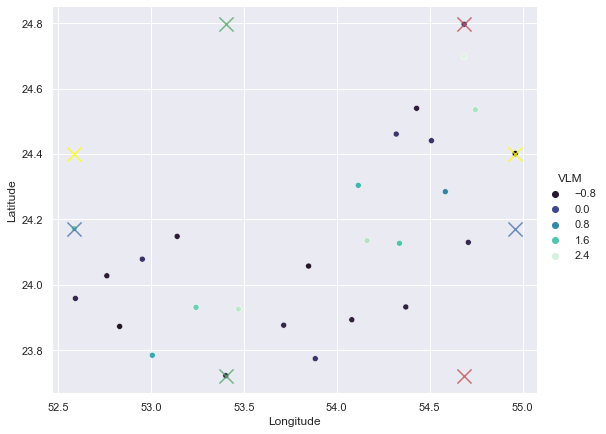

In [8]:
sns.relplot(x="Longitude", y="Latitude", hue="VLM", data=vlm, palette="mako", height=6, aspect=1.25)
plt.scatter(top_pair[0], top_pair[1], c='r', marker='x', s=200, alpha=0.8)
plt.scatter(bottom_pair[0], bottom_pair[1], c='g', marker='x', s=200, alpha=0.8)
plt.scatter(left_pair[0], left_pair[1], c='b', marker='x', s=200, alpha=0.8)
plt.scatter(right_pair[0], right_pair[1], c='yellow', marker='x', s=200, alpha=0.8)

In [9]:
from math import radians, cos, sin, asin, sqrt
def distance(lon1, lat1, lon2, lat2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in meters. Use 3956 for miles
    r = 6371*1000
      
    # calculate the result
    return(c * r)

In [10]:
# Distances of vertical pairs (top & bottom)
ver_top = distance(top.Longitude, top.Latitude, top_counter[0], top_counter[1])
ver_bottom = distance(bottom.Longitude, bottom.Latitude, bottom_counter[0], bottom_counter[1])
# Distances of horizontal pairs (left & right)
hor_left = distance(left.Longitude, left.Latitude, left_counter[0], left_counter[1])
hor_right = distance(right.Longitude, right.Latitude, right_counter[0], right_counter[1])

In [11]:
# There is some slight difference so I'm taking the rounded mean values
dis_ver = np.ceil(np.mean((ver_top, ver_bottom)))
dis_hor = np.ceil(np.mean((hor_left, hor_right)))

In [12]:
# Boundary values
x_min, x_max = vlm.min().Longitude, vlm.max().Longitude
y_min, y_max = vlm.min().Latitude, vlm.max().Latitude

In [13]:
# Divide by distance of 10m seems a bit too detailed. Trying with adding points every 100m instead
nx, ny = (np.int(np.ceil(dis_ver / 100)), np.int(np.ceil(dis_hor / 100)))
x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)
xv, yv = np.meshgrid(x, y)

<ipython-input-13-9eeb23183f3a>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nx, ny = (np.int(np.ceil(dis_ver / 100)), np.int(np.ceil(dis_hor / 100)))


In [14]:
vlm_points = vlm[['Longitude', 'Latitude']].values
vlm_values = vlm.VLM.values

In [15]:
vlm_grid = griddata(vlm_points, vlm_values, (xv, yv), method='cubic')

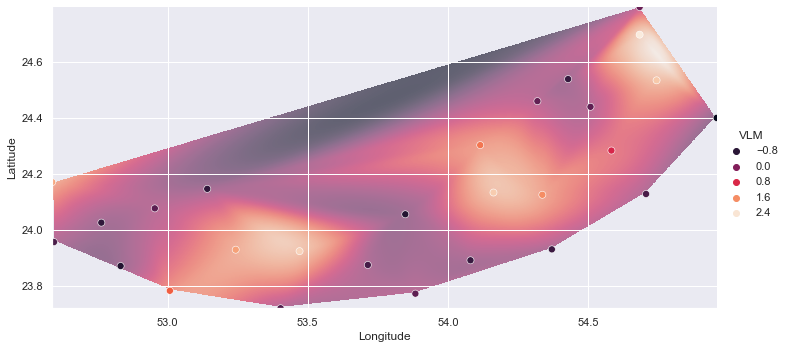

In [16]:
sns.relplot(x="Longitude", y="Latitude", hue="VLM", data=vlm, s=50, palette="rocket", height=10)
plt.imshow(vlm_grid, extent=(x_min, x_max, y_min, y_max), origin='lower', alpha=0.6)
plt.show()

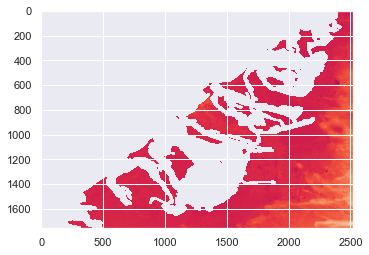

In [17]:
elevation_new = copy.deepcopy(elevation)

elevation_new = elevation_new.astype('float')
elevation_new[elevation_new == 32767] = np.nan

plt.imshow(elevation_new)

Idea: flatten the coordinate grid into pairs of coordinates to use as inputs for another interpolation

In [18]:
vlm_inter_points = np.hstack((xv.reshape(-1, 1), yv.reshape(-1, 1)))

In [19]:
vlm_inter_values = vlm_grid.flatten()

In [20]:
elev_coor = elevation_df[['x', 'y']].values

In [21]:
elev_grid_0 = griddata(vlm_points, vlm_values, elev_coor, method='cubic') # without pre-interpolation
elev_grid_1 = griddata(vlm_inter_points, vlm_inter_values, elev_coor, method='cubic') # with pre-interpolation

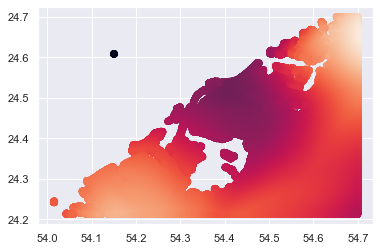

In [22]:
plt.scatter(x=elevation_df.x, y=elevation_df.y, c=elev_grid_0)

In [23]:
# Find elevation map boundaries
x_min_elev = dataset.bounds.left
x_max_elev = dataset.bounds.right
y_min_elev = dataset.bounds.bottom
y_max_elev = dataset.bounds.top

# Create elevation meshgrid
nyy, nxx = elevation_new.shape
xx = np.linspace(x_min_elev, x_max_elev, nxx)
yy = np.linspace(y_min_elev, y_max_elev, nyy)
xxv, yyv = np.meshgrid(xx, yy)

xxv.shape, yyv.shape

((1758, 2521), (1758, 2521))

elev_grid = griddata(vlm_inter_points, vlm_inter_values, (xxv, yyv), method='linear')

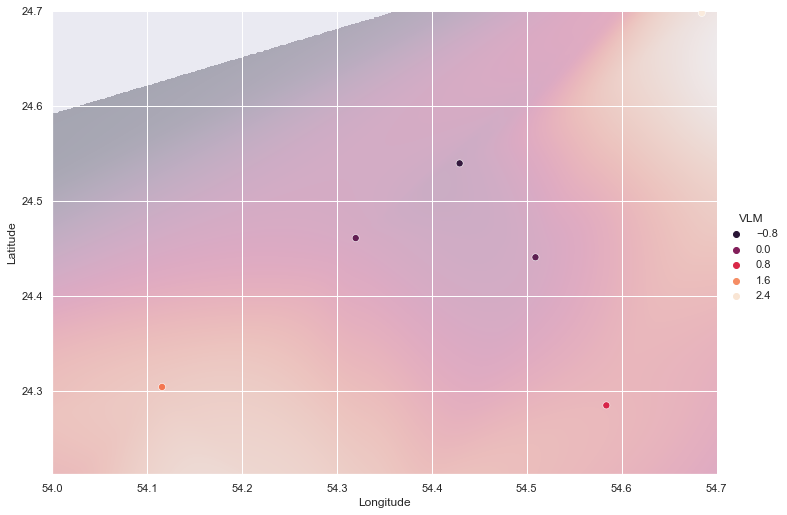

In [24]:
sns.relplot(x="Longitude", y="Latitude", hue="VLM", data=vlm, s=50, palette="rocket", height=10)
plt.imshow(elev_grid, extent=(x_min_elev, x_max_elev, y_min_elev, y_max_elev), origin="lower", alpha=0.3)
plt.show()

In [25]:
elev_grid_copy = copy.deepcopy(elev_grid)

In [26]:
elev_grid_copy[np.isnan(np.flip(elevation_new, 0))] = np.nan
# Needs to flip elevation array vertically. I don't really understand why.

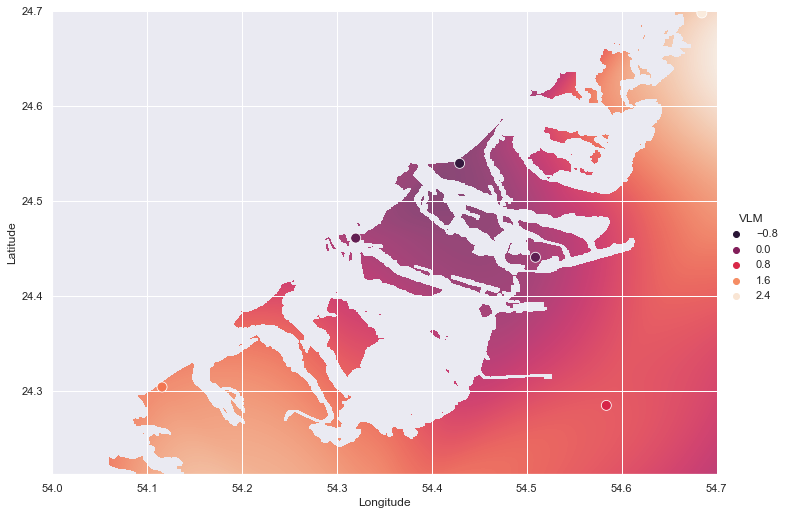

In [27]:
sns.relplot(x="Longitude", y="Latitude", hue="VLM", data=vlm, s=100, edgecolor="white", palette="rocket", height=10)
plt.imshow(elev_grid_copy, extent=(x_min_elev, x_max_elev, y_min_elev, y_max_elev), origin='lower', alpha=0.8)
plt.show()

# **the interpolated VLM values are stored in: elev_grid_copy

# Calculating AE:

In [28]:
slr_new = slr_df.loc[(slr_df.Scenario == '0.3 - LOW') |  (slr_df.Scenario == '2.5 - HIGH')]
slr_new['SL'] = slr_new.sum(axis=1)

<ipython-input-28-7a096f60d5cf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slr_new['SL'] = slr_new.sum(axis=1)


In [29]:
ae_low = copy.deepcopy(elev_grid_copy)
ae_high = copy.deepcopy(elev_grid_copy)

In [30]:
# Division by 100 to fix unit difference
ae_low = np.flip(elevation_new, 0) - slr_new.iloc[0].SL/100 + ae_low
ae_high = np.flip(elevation_new, 0) - slr_new.iloc[1].SL/100 + ae_high

In [31]:
ae_min = min(ae_low[~np.isnan(ae_low)].min(), ae_high[~np.isnan(ae_high)].min())
ae_max = max(ae_low[~np.isnan(ae_low)].max(), ae_high[~np.isnan(ae_high)].max())

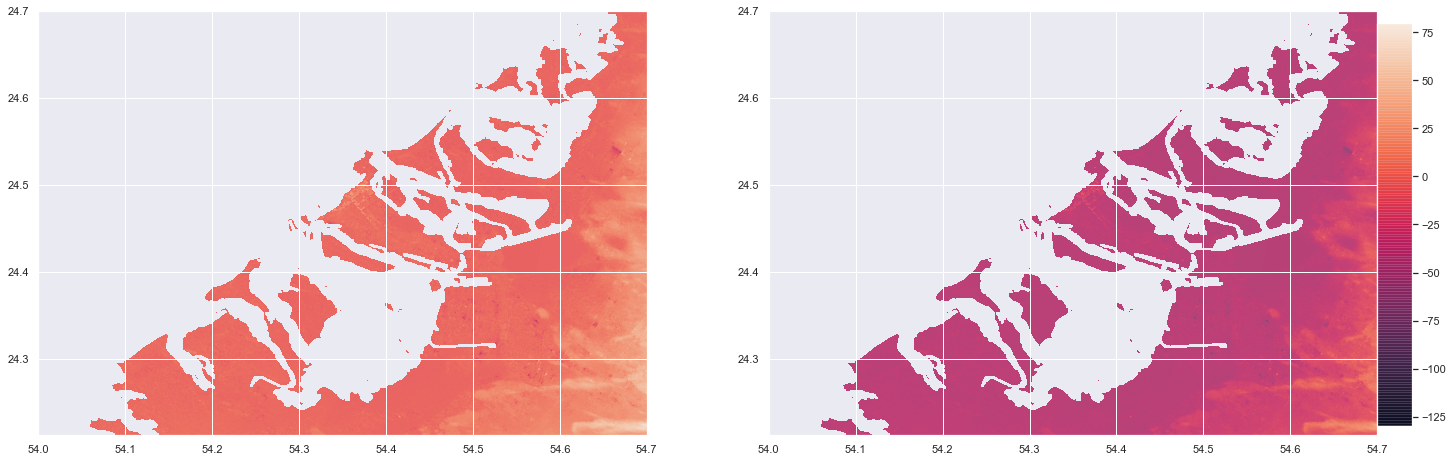

In [32]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(24, 8))
im1 = ax1.imshow(ae_low, extent=(x_min_elev, x_max_elev, y_min_elev, y_max_elev), origin='lower', alpha=0.8, vmin=ae_min, vmax=ae_max)
im2 = ax2.imshow(ae_high, extent=(x_min_elev, x_max_elev, y_min_elev, y_max_elev), origin='lower', alpha=0.8, vmin=ae_min, vmax=ae_max)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(im2, cax=cbar_ax)

# Elevation-Habitat Map:

elev_habit_map

In [33]:
from time import time
from shapely.geometry import Point, Polygon
from shapely.ops import cascaded_union

In [34]:
t00 = time()
# file = gr.from_file('../Week 6/Elevation.tif')
# elevation_df = file.to_geopandas()

habitat_path = r"Data/UAE_habitats_new1.shp"
habitat = gpd.read_file(habitat_path)

elevation_df.to_crs(habitat.crs, inplace=True)

elev_bounds = elevation_df.total_bounds

print("Loading files: %.2fs" % (time() - t00))

Loading files: 19.80s


In [35]:
# Create boundary points
# Top left - top right - bottom right - bottom left
tl = Point(elev_bounds[0], elev_bounds[3])
tr = Point(elev_bounds[2], elev_bounds[3])
br = Point(elev_bounds[2], elev_bounds[1])
bl = Point(elev_bounds[0], elev_bounds[1])

boundary = Polygon([tl, tr, br, bl])

boundary_df = gpd.GeoSeries(boundary)

In [36]:
# Intersecting original habitat with bounding box
habitat['Intersection'] = habitat.geometry.intersects(boundary)
habitat_cut = habitat[habitat.Intersection == True]

In [37]:
t0 = time()
elev_union_shape = cascaded_union(list(elevation_df.geometry))
print("Merging elevation geometries into one polygon: %.2fs" % (time() - t0))

Merging elevation geometries into one polygon: 319.92s


In [38]:
elev_union = gpd.GeoSeries(elev_union_shape)
elev_union_df = gpd.GeoDataFrame({'geometry': elev_union})
elev_union_df.crs = habitat.crs
elev_union.crs = habitat.crs
elev_union_shape.crs = habitat.crs

In [39]:
t1 = time()
habitat_cut['Intersection_2'] = habitat_cut.geometry.intersects(elev_union_shape)
print("Intersecting reduced habitat map with elevation polygon: %.2fs" % (time() - t1))

Intersecting reduced habitat map with elevation polygon: 419.59s


/opt/anaconda3/envs/SLResearch/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [40]:
habitat_cut_cut = habitat_cut[habitat_cut['Intersection_2'] == True]

In [41]:
t2 = time()
final = gpd.sjoin(elevation_df, habitat_cut_cut, how="left", op="within")
print("Joining elevation df with habitat_cut_cut: %.2fs" % (time() - t2))

Joining elevation df with habitat_cut_cut: 58.04s


In [42]:
def fillna_nearest(series):
    fact = series.astype('category').factorize()

    series_cat = gpd.GeoSeries(fact[0]).replace(-1, np.nan) # get string as categorical (-1 is NaN)
    series_cat_interp = series_cat.interpolate("nearest") # interpolate categorical

    cat_to_string = {i:x for i,x in enumerate(fact[1])} # dict connecting category to string
    series_str_interp = series_cat_interp.map(cat_to_string) # turn category back to string

    return series_str_interp

In [43]:
t3 = time()
final['Fill'] = fillna_nearest(final.Habitats)
print("Interpolating missing values in final df: %.2fs" % (time() - t3))

<ipython-input-42-48fff6ddc758>:4: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  series_cat = gpd.GeoSeries(fact[0]).replace(-1, np.nan) # get string as categorical (-1 is NaN)


Interpolating missing values in final df: 0.72s


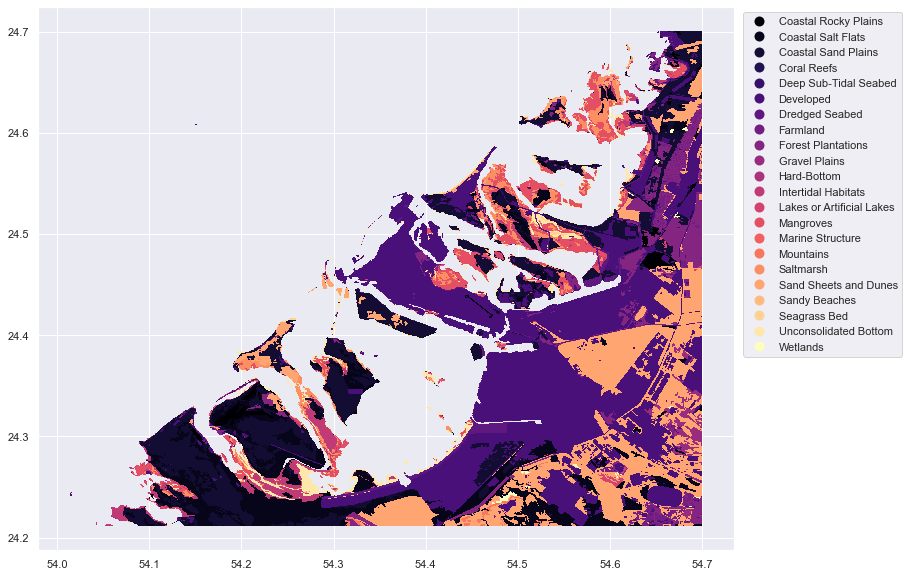

Plotting final df: 405.34s


In [44]:
t4 = time()
f, ax = plt.subplots(1, 1, figsize=(14, 10))
ax = final.plot(column='Fill', ax=ax, legend=True, cmap='magma', edgecolor="face", linewidth=0.)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.25, 1))
plt.show()
print("Plotting final df: %.2fs" % (time() - t4))

# Habitats Grouping:

In [45]:
elev_habit_map = final.drop(columns=["col", "index_right", "OBJECTID", "Id", "HabitatTyp", "HabitatT_1", "HabitatSub", "HabitatS_1",
                             "RuleID", "Shape_Leng", "Shape_Area", "Habitats", "Intersection", "Intersection_2"], axis=1)

In [46]:
elev_habit_map.rename(columns={"Fill": "Habitats"}, inplace=True)

In [47]:
# Create New Column for New Habitat Groups:
elev_habit_map['Habitat_Groups'] = ''
elev_habit_map.head(1)

,row,value,x,y,geometry,Habitats,Habitat_Groups
0,0,1.0,54.651806,24.700139,"POLYGON ((54.65181 24.70014, 54.65208 24.70014...",Developed,


In [48]:
np.unique(elev_habit_map.Habitats)

array(['Coastal Rocky Plains', 'Coastal Salt Flats',
       'Coastal Sand Plains', 'Coral Reefs', 'Deep Sub-Tidal Seabed',
       'Developed', 'Dredged Seabed', 'Farmland', 'Forest Plantations',
       'Gravel Plains', 'Hard-Bottom', 'Intertidal Habitats',
       'Lakes or Artificial Lakes', 'Mangroves', 'Marine Structure',
       'Mountains', 'Saltmarsh', 'Sand Sheets and Dunes', 'Sandy Beaches',
       'Seagrass Bed', 'Unconsolidated Bottom', 'Wetlands'], dtype=object)

In [49]:
elev_habit_map.loc[ (elev_habit_map.Habitats == 'Marine Structure')
                   | (elev_habit_map.Habitats == 'Developed')
                   | (elev_habit_map.Habitats == 'Dredged Area Wall') 
                   | (elev_habit_map.Habitats == 'Dredged Seabed')
                   | (elev_habit_map.Habitats == 'Farmland') 
                   , 'Habitat_Groups'] = 'Developed'

In [50]:
elev_habit_map.loc[ (elev_habit_map.Habitats == 'Mountains')
                   | (elev_habit_map.Habitats == 'Coastal Cliff')
                   | (elev_habit_map.Habitats == 'Coastal Rocky Plains') 
                   | (elev_habit_map.Habitats == 'Gravel Plains')
                   | (elev_habit_map.Habitats == 'Rock Armouring / Artificial Reef') 
                   | (elev_habit_map.Habitats == 'Rocky Beaches')
                   | (elev_habit_map.Habitats == 'Storm Beach Ridges') 
                   , 'Habitat_Groups'] = 'Rocky'

In [51]:
elev_habit_map.loc[ (elev_habit_map.Habitats == 'Mega Dunes')
                   | (elev_habit_map.Habitats == 'Sand Sheets and Dunes')
                   | (elev_habit_map.Habitats == 'Sandy Beaches')
                   | (elev_habit_map.Habitats == 'Coastal Sand Plains')
                   , 'Habitat_Groups'] = 'Sandy'

In [52]:
elev_habit_map.loc[ (elev_habit_map.Habitats == 'Coastal Salt Flats')
                   | (elev_habit_map.Habitats == 'Inland Salt Flats')
                   | (elev_habit_map.Habitats == 'Saltmarsh')
                   | (elev_habit_map.Habitats == 'Intertidal Habitats')
                   | (elev_habit_map.Habitats == 'Wetlands')
                   , 'Habitat_Groups'] = 'Marsh/Salt Flats'

In [53]:
elev_habit_map.loc[ (elev_habit_map.Habitats == 'Coral Reefs')
                   | (elev_habit_map.Habitats == 'Deep Sub-Tidal Seabed')
                   | (elev_habit_map.Habitats == 'Hard-Bottom') 
                   | (elev_habit_map.Habitats == 'Seagrass Bed')
                   | (elev_habit_map.Habitats == 'Lakes or Artificial Lakes')
                   | (elev_habit_map.Habitats == 'Unconsolidated Bottom')
                   , 'Habitat_Groups'] = 'Subaqueous'

In [54]:
elev_habit_map.loc[ (elev_habit_map.Habitats == 'Forest Plantations')
                   | (elev_habit_map.Habitats == 'Mangroves') 
                   , 'Habitat_Groups'] = 'Forest'

In [55]:
# Be carful: it is spelled: 'Coastal Sand Plains' NOT: 'Coastal Sand Planes'
unique_groups = np.unique(elev_habit_map.Habitat_Groups)
print(unique_groups)
print(len(unique_groups))
# elev_habit_map.loc[elev_habit_map.Habitat_Groups == '']  #--> to see which rows still didnt have a group assigned to them

['Developed' 'Forest' 'Marsh/Salt Flats' 'Rocky' 'Sandy' 'Subaqueous']
6


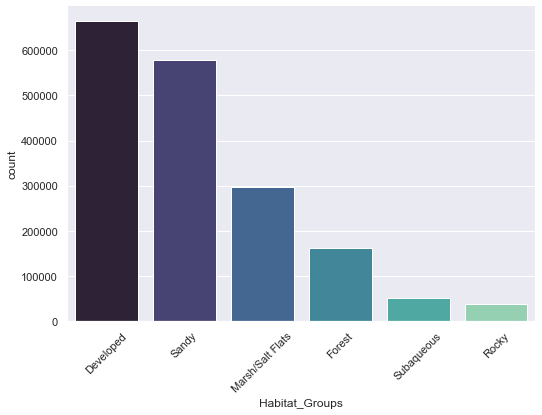

In [56]:
sns.catplot(x="Habitat_Groups", kind="count", palette="mako", data=elev_habit_map, height=5, aspect=1.5)
labels = plt.xticks(rotation=45)

In [57]:
# elev_habit_map

In [58]:
# model_mit = pgmpy.models.BayesianModel([('SLR', 'AE'), ('VLM', 'AE'), ('Elevation', 'AE'), ('Elevation', 'Habitat'), ('Habitat', 'CR'), ('AE', 'CR')])



In [59]:
# vlm_bins_df

# **The Elev-Habit DF now has habitat groups & it is called: 'elev_habit_map'

# VLM Bins & Habitat Classes:

# 1. VLM Bins:

In [60]:
print(len(elev_grid_copy))
print(type(elev_grid_copy))
print(type(elev_grid_copy.flatten()))

1758
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [61]:
# Dropping the NaN values in the array:
nan_array = np.isnan(elev_grid_copy.flatten())
not_nan_array = ~ nan_array
vlm_interpolated_arr = elev_grid_copy.flatten()[not_nan_array]
vlm_interpolated_arr

array([1.16874389, 1.17216239, 1.17560947, ..., 2.58071978, 2.58240221,
       2.58408464])

# **The clean, flattened VLM array for interpolated VLM values is called:              
# 'vlm_interpolated_arr'

In [62]:
# Step 1: Making 3 equal-size bins for VLM data: note: interval differences are irrelevant 

vlm_bins = pd.qcut(vlm_interpolated_arr, q=3, precision=1, labels=['Bin #1', 'Bin #2', 'Bin #3'])

# bin definition
bins  = vlm_bins.categories
print(bins)
# bin corresponding to each point in data
codes = vlm_bins.codes
print(np.unique(codes))

Index(['Bin #1', 'Bin #2', 'Bin #3'], dtype='object')
[0 1 2]


Counter({2: 596554, 0: 596554, 1: 596553})
   Bin Index  Frequency
0          2     596554
1          0     596554
2          1     596553


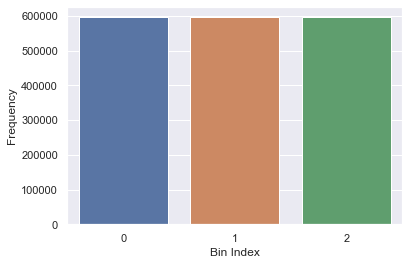

In [63]:
# Step 2: Making Sure that the Bins are of Almost Equal Size:
size = collections.Counter(codes)
print(size)

d_table = pd.value_counts(codes).to_frame(name='Frequency')
d_table = d_table.reset_index()
d_table = d_table.rename(columns={'index': 'Bin Index'})
fig, ax = plt.subplots()
sns.barplot(x="Bin Index", y="Frequency", data=d_table, label="Size of Each of the 3 Bins", ax=ax)
print(d_table)

In [64]:
# Step 3: Calculating Probability of each Bin:
prob0 = (d_table.loc[0].Frequency)/len(vlm_interpolated_arr)
prob1 = (d_table.loc[1].Frequency)/len(vlm_interpolated_arr)
prob2 = (d_table.loc[2].Frequency)/len(vlm_interpolated_arr)
print(prob0, prob1, prob2)

0.3333335195883466 0.3333335195883466 0.33333296082330677


In [65]:
# Step 4: Joining Everything in a Single Data Frame for aesthetic:
vlm_bins_df = pd.DataFrame()

vlm_bins_df['VLM Values'] = vlm_interpolated_arr
vlm_bins_df['Bins'] = vlm_bins
vlm_bins_df['Intervals'] = pd.qcut(vlm_interpolated_arr, q=3, precision=1)

vlm_bins_df['Probability'] = ''
vlm_bins_df.loc[ (vlm_bins_df.Bins == 'Bin #1'), 'Probability'] = prob0
vlm_bins_df.loc[ (vlm_bins_df.Bins == 'Bin #2'), 'Probability'] = prob1
vlm_bins_df.loc[ (vlm_bins_df.Bins == 'Bin #3'), 'Probability'] = prob2

vlm_bins_df.head()

,VLM Values,Bins,Intervals,Probability
0,1.168744,Bin #3,"(1.0, 2.9]",0.333333
1,1.172162,Bin #3,"(1.0, 2.9]",0.333333
2,1.175609,Bin #3,"(1.0, 2.9]",0.333333
3,1.179118,Bin #3,"(1.0, 2.9]",0.333333
4,1.182627,Bin #3,"(1.0, 2.9]",0.333333


# 2. Elevation Classes:

In [66]:
# Step 1: Create Data Frame:
elevation_classes = pd.DataFrame()
elevation_classes['Elevation_Values'] = elevation_df.value

In [67]:
# Step 2: Get Max and Min Values for Elevation
min_elev = elevation_df.value.min()
max_elev = elevation_df.value.max()

In [68]:
# Step 3: Create Intervals:
interval_0 = pd.cut(x=elevation_df['value'], bins=[1, 5, 10, max_elev])
interval_1 = pd.cut(x=elevation_df['value'], bins=[min_elev, -10, -1, 0], right=False)
interval_2 = pd.cut(x=elevation_df['value'], bins=[0, 1], include_lowest=True)

In [69]:
# Step 4: Add intervals to dataframe:
elevation_classes['Intervals_0'] = interval_0
elevation_classes['Intervals_1'] = interval_1
elevation_classes['Intervals_2'] = interval_2
elevation_classes['Intervals'] = ''

elevation_classes.loc[ ((elevation_classes.Intervals_0.isnull()) & (elevation_classes.Intervals_1.isnull())), 'Intervals'] = interval_2
elevation_classes.loc[ ((elevation_classes.Intervals_0.isnull()) & (elevation_classes.Intervals_2.isnull())), 'Intervals'] = interval_1
elevation_classes.loc[ ((elevation_classes.Intervals_1.isnull()) & (elevation_classes.Intervals_2.isnull())), 'Intervals'] = interval_0

elevation_classes.drop(['Intervals_2', 'Intervals_1', 'Intervals_0'], axis='columns', inplace=True)

Counter({Interval(1.0, 5.0, closed='right'): 603235, Interval(10.0, 83.0, closed='right'): 409264, Interval(-0.001, 1.0, closed='right'): 389632, Interval(5.0, 10.0, closed='right'): 231449, Interval(-1.0, 0.0, closed='left'): 77165, Interval(-10.0, -1.0, closed='left'): 76021, Interval(-89.0, -10.0, closed='left'): 2895})
      Class Index  Frequency
0      (1.0, 5.0]     603235
1    (10.0, 83.0]     409264
2   (-0.001, 1.0]     389632
3     (5.0, 10.0]     231449
4     [-1.0, 0.0)      77165
5   [-10.0, -1.0)      76021
6  [-89.0, -10.0)       2895


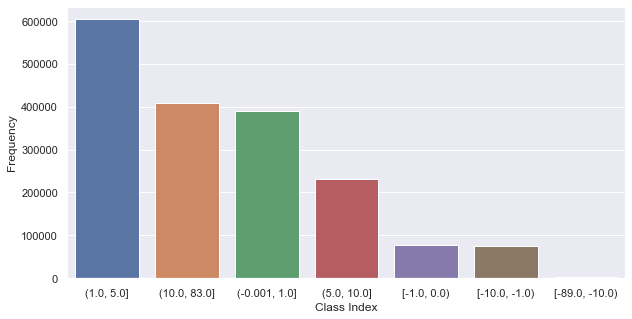

In [70]:
# Step 5: Plotting the Size of Each Interval:
size = collections.Counter(elevation_classes.Intervals)
print(size)

d_table_elev = pd.value_counts(elevation_classes.Intervals).to_frame(name='Frequency')
d_table_elev = d_table_elev.reset_index()
d_table_elev = d_table_elev.rename(columns={'index': 'Class Index'})
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="Class Index", y="Frequency", data=d_table_elev, label="Size of Each Class", ax=ax)
print(d_table_elev)

In [71]:
# Step 6: Calculate Probabilities:
prob0_elev = (d_table_elev.loc[6].Frequency)/len(elevation_classes)   # [min_elev, -10)
prob1_elev = (d_table_elev.loc[5].Frequency)/len(elevation_classes)   # [-10, -1)
prob2_elev = (d_table_elev.loc[4].Frequency)/len(elevation_classes)   # [-1, 0)
prob3_elev = (d_table_elev.loc[2].Frequency)/len(elevation_classes)   # [0, 1]
prob4_elev = (d_table_elev.loc[0].Frequency)/len(elevation_classes)   # (1, 5]
prob5_elev = (d_table_elev.loc[3].Frequency)/len(elevation_classes)   # (5, 10]
prob6_elev = (d_table_elev.loc[1].Frequency)/len(elevation_classes)   # (10, max_elev]

print(prob0_elev, prob1_elev, prob2_elev, prob3_elev, prob4_elev, prob5_elev, prob6_elev)

0.0016176247903932645 0.042477877095159364 0.04311710430075864 0.2177127400105383 0.33706662881964794 0.12932560971044238 0.2286824152730601


In [72]:
# Step 7: Adding probabilities to d_table_elev for visualization:
d_table_elev['Probability'] = ''
d_table_elev['Probability'].loc[0] = prob4_elev
d_table_elev['Probability'].loc[1] = prob6_elev
d_table_elev['Probability'].loc[2] = prob3_elev
d_table_elev['Probability'].loc[3] = prob5_elev
d_table_elev['Probability'].loc[4] = prob2_elev
d_table_elev['Probability'].loc[5] = prob1_elev
d_table_elev['Probability'].loc[6] = prob0_elev
d_table_elev

/opt/anaconda3/envs/SLResearch/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Class Index,Frequency,Probability
0,"(1.0, 5.0]",603235,0.337067
1,"(10.0, 83.0]",409264,0.228682
2,"(-0.001, 1.0]",389632,0.217713
3,"(5.0, 10.0]",231449,0.129326
4,"[-1.0, 0.0)",77165,0.0431171
5,"[-10.0, -1.0)",76021,0.0424779
6,"[-89.0, -10.0)",2895,0.00161762


# SLR Scenarios:

# Add VLM:

In [73]:
vlm_interpolated_arr


array([1.16874389, 1.17216239, 1.17560947, ..., 2.58071978, 2.58240221,
       2.58408464])

In [74]:
inter_vlm_df = pd.DataFrame(vlm_interpolated_arr, columns=['VLM'])


In [75]:
elev_habit_map['VLM'] = inter_vlm_df.VLM/1000


In [76]:
elev_habit_map.VLM.value_counts(dropna=False)

0.000762    1
0.000771    1
0.001891    1
0.000786    1
0.001998    1
           ..
0.001790    1
0.001743    1
0.001663    1
0.002495    1
0.000860    1
Name: VLM, Length: 1789661, dtype: int64

In [77]:
elev_habit_map['Migitation 46-65'] = elev_habit_map.value - 0.27 + elev_habit_map.VLM
elev_habit_map['Intermediate 46-65'] = elev_habit_map.value - 0.3 + elev_habit_map.VLM
elev_habit_map['Intermediate-High 46-65'] = elev_habit_map.value - 0.28 + elev_habit_map.VLM
elev_habit_map['High 46-65'] = elev_habit_map.value - 0.33 + elev_habit_map.VLM
elev_habit_map.head()

,row,value,x,y,geometry,Habitats,Habitat_Groups,VLM,Migitation 46-65,Intermediate 46-65,Intermediate-High 46-65,High 46-65
0,0,1.0,54.651806,24.700139,"POLYGON ((54.65181 24.70014, 54.65208 24.70014...",Developed,Developed,0.001169,0.731169,0.701169,0.721169,0.671169
1,0,0.0,54.652084,24.700139,"POLYGON ((54.65208 24.70014, 54.65236 24.70014...",Developed,Developed,0.001172,-0.268828,-0.298828,-0.278828,-0.328828
2,0,1.0,54.652361,24.700139,"POLYGON ((54.65236 24.70014, 54.65264 24.70014...",Developed,Developed,0.001176,0.731176,0.701176,0.721176,0.671176
3,0,1.0,54.652639,24.700139,"POLYGON ((54.65264 24.70014, 54.65292 24.70014...",Developed,Developed,0.001179,0.731179,0.701179,0.721179,0.671179
4,0,2.0,54.652917,24.700139,"POLYGON ((54.65292 24.70014, 54.65319 24.70014...",Developed,Developed,0.001183,1.731183,1.701183,1.721183,1.671183


In [78]:
temp = pd.DataFrame()
temp['AE'] = elev_habit_map['Migitation 46-65']
temp['Elevation'] = elev_habit_map['value']
temp['Habitats'] = elev_habit_map['Habitats']
temp['VLM'] = elev_habit_map['VLM']


temp['SLR'] = 0.27
temp.head()






,AE,Elevation,Habitats,VLM,SLR
0,0.731169,1.0,Developed,0.001169,0.27
1,-0.268828,0.0,Developed,0.001172,0.27
2,0.731176,1.0,Developed,0.001176,0.27
3,0.731179,1.0,Developed,0.001179,0.27
4,1.731183,2.0,Developed,0.001183,0.27


In [79]:
temp.to_csv('data/final.csv',sep='\t') # Use Tab to seperate data


# AE Bins:

In [ ]:
# # Step 1: Create Data Frame for each scenario:
# mitigation_df = pd.DataFrame()
# mitigation_df['AE_Values'] = elev_habit_map['Migitation 46-65']

# inter_df = pd.DataFrame()
# inter_df['AE_Values'] = elev_habit_map['Intermediate 46-65']

# inter_high_df = pd.DataFrame()
# inter_high_df['AE_Values'] = elev_habit_map['Intermediate-High 46-65']

# high_df = pd.DataFrame()
# high_df['AE_Values'] = elev_habit_map['High 46-65']

In [ ]:
# # Step 2: Find min and max values for each df:
# # Mitigation df:
# min_mit = mitigation_df.AE_Values.min()
# max_mit = mitigation_df.AE_Values.max()
# # Intermediate df:
# min_inter = inter_df.AE_Values.min()
# max_inter = inter_df.AE_Values.max()
# # Intermediate-High df:
# min_inter_high = inter_high_df.AE_Values.min()
# max_inter_high = inter_high_df.AE_Values.max()
# # High df:
# min_high = high_df.AE_Values.min()
# max_high = high_df.AE_Values.max()

In [ ]:
# # Step 3: Create Intervals for each df:
# # intervals are for all slr data frame:
# interval_0_mit = pd.cut(x=mitigation_df['AE_Values'], bins=[1, 5, 10, max_mit])
# interval_1_mit = pd.cut(x=mitigation_df['AE_Values'], bins=[min_mit, -12, -1, 0], right=False)
# interval_2_mit = pd.cut(x=mitigation_df['AE_Values'], bins=[0, 1], include_lowest=True)

In [ ]:
# # Step 4: Add intervals to dataframe:
# # Intermediate df:
# inter_df['Intervals_0'] = interval_0_mit
# inter_df['Intervals_1'] = interval_1_mit
# inter_df['Intervals_2'] = interval_2_mit
# inter_df['Intervals'] = ''

# inter_df.loc[ ((inter_df.Intervals_0.isnull()) & (inter_df.Intervals_1.isnull())), 'Intervals'] = interval_2_mit
# inter_df.loc[ ((inter_df.Intervals_0.isnull()) & (inter_df.Intervals_2.isnull())), 'Intervals'] = interval_1_mit
# inter_df.loc[ ((inter_df.Intervals_1.isnull()) & (inter_df.Intervals_2.isnull())), 'Intervals'] = interval_0_mit

# inter_df.drop(['Intervals_2', 'Intervals_1', 'Intervals_0'], axis='columns', inplace=True)

# # Mitigation df:
# mitigation_df['Intervals_0'] = interval_0_mit
# mitigation_df['Intervals_1'] = interval_1_mit
# mitigation_df['Intervals_2'] = interval_2_mit
# mitigation_df['Intervals'] = ''

# mitigation_df.loc[ ((mitigation_df.Intervals_0.isnull()) & (mitigation_df.Intervals_1.isnull())), 'Intervals'] = interval_2_mit
# mitigation_df.loc[ ((mitigation_df.Intervals_0.isnull()) & (mitigation_df.Intervals_2.isnull())), 'Intervals'] = interval_1_mit
# mitigation_df.loc[ ((mitigation_df.Intervals_1.isnull()) & (mitigation_df.Intervals_2.isnull())), 'Intervals'] = interval_0_mit

# mitigation_df.drop(['Intervals_2', 'Intervals_1', 'Intervals_0'], axis='columns', inplace=True)

# # Intermediate-High df:
# inter_high_df['Intervals_0'] = interval_0_mit
# inter_high_df['Intervals_1'] = interval_1_mit
# inter_high_df['Intervals_2'] = interval_2_mit
# inter_high_df['Intervals'] = ''

# inter_high_df.loc[ ((inter_high_df.Intervals_0.isnull()) & (inter_high_df.Intervals_1.isnull())), 'Intervals'] = interval_2_mit
# inter_high_df.loc[ ((inter_high_df.Intervals_0.isnull()) & (inter_high_df.Intervals_2.isnull())), 'Intervals'] = interval_1_mit
# inter_high_df.loc[ ((inter_high_df.Intervals_1.isnull()) & (inter_high_df.Intervals_2.isnull())), 'Intervals'] = interval_0_mit

# inter_high_df.drop(['Intervals_2', 'Intervals_1', 'Intervals_0'], axis='columns', inplace=True)

# # High df:
# high_df['Intervals_0'] = interval_0_mit
# high_df['Intervals_1'] = interval_1_mit
# high_df['Intervals_2'] = interval_2_mit
# high_df['Intervals'] = ''

# high_df.loc[ ((high_df.Intervals_0.isnull()) & (high_df.Intervals_1.isnull())), 'Intervals'] = interval_2_mit
# high_df.loc[ ((high_df.Intervals_0.isnull()) & (high_df.Intervals_2.isnull())), 'Intervals'] = interval_1_mit
# high_df.loc[ ((high_df.Intervals_1.isnull()) & (high_df.Intervals_2.isnull())), 'Intervals'] = interval_0_mit

# high_df.drop(['Intervals_2', 'Intervals_1', 'Intervals_0'], axis='columns', inplace=True)

In [ ]:
# # Step 5: Plotting the Size of Each Interval:
# # Mitigation df:
# size = collections.Counter(mitigation_df.Intervals)
# print(size)

# d_table_mit = pd.value_counts(mitigation_df.Intervals).to_frame(name='Frequency')
# d_table_mit = d_table_mit.reset_index()
# d_table_mit = d_table_mit.rename(columns={'index': 'Class Index'})
# fig, ax = plt.subplots(figsize=(10, 5))
# sns.barplot(x="Class Index", y="Frequency", data=d_table_mit, label="Size of Each Class", ax=ax)
# print(d_table_mit)

# # Intermediate df:
# d_table_inter = pd.value_counts(inter_df.Intervals).to_frame(name='Frequency')
# d_table_inter = d_table_inter.reset_index()
# d_table_inter = d_table_inter.rename(columns={'index': 'Class Index'})

# # Intermediate-High df:
# d_table_inter_high = pd.value_counts(inter_high_df.Intervals).to_frame(name='Frequency')
# d_table_inter_high = d_table_inter_high.reset_index()
# d_table_inter_high = d_table_inter_high.rename(columns={'index': 'Class Index'})

# # High df:
# size = collections.Counter(high_df.Intervals)
# print(size)

# d_table_high = pd.value_counts(high_df.Intervals).to_frame(name='Frequency')
# d_table_high = d_table_high.reset_index()
# d_table_high = d_table_high.rename(columns={'index': 'Class Index'})
# fig, ax = plt.subplots(figsize=(10, 5))
# sns.barplot(x="Class Index", y="Frequency", data=d_table_high, label="Size of Each Class", ax=ax)
# print(d_table_high)

In [ ]:
# mitigation_count = pd.DataFrame(mitigation_df.Intervals.value_counts())
# mitigation_count.sort_index(inplace=True)
# mitigation_count

In [ ]:
# sns.barplot(x=mitigation_count.index, y="Intervals", palette="mako", data=mitigation_count)

# Calculating Probabilities of Each Scenario:

In [ ]:
# # Mitigation: 
# d_table_mit['Probability'] = (d_table_mit.Frequency)/(d_table_mit.Frequency.sum())
# d_table_inter['Probability'] = (d_table_inter.Frequency)/(d_table_inter.Frequency.sum())
# d_table_inter_high['Probability'] = (d_table_inter_high.Frequency)/(d_table_inter_high.Frequency.sum())
# d_table_high['Probability'] = (d_table_high.Frequency)/(d_table_high.Frequency.sum())

# BN Model:

In [ ]:
# # Build the networks:
# model_mit = pgmpy.models.BayesianModel([('SLR', 'AE'), ('VLM', 'AE'), ('Elevation', 'AE'), ('Elevation', 'Habitat'), ('Habitat', 'CR'), ('AE', 'CR')])
# model_inter = pgmpy.models.BayesianModel([('SLR', 'AE'), ('VLM', 'AE'), ('Elevation', 'AE'), ('Elevation', 'Habitat'), ('Habitat', 'CR'), ('AE', 'CR')])
# model_inter_high = pgmpy.models.BayesianModel([('SLR', 'AE'), ('VLM', 'AE'), ('Elevation', 'AE'), ('Elevation', 'Habitat'), ('Habitat', 'CR'), ('AE', 'CR')])
# model_high = pgmpy.models.BayesianModel([('SLR', 'AE'), ('VLM', 'AE'), ('Elevation', 'AE'), ('Elevation', 'Habitat'), ('Habitat', 'CR'), ('AE', 'CR')])

In [ ]:
# # CPDs for SLR for models:
# cpd_slr_mit = pgmpy.factors.discrete.TabularCPD('SLR', 4, [[1], [0], [0], [0]], state_names={'SLR': ['0.18-0.34', '0.2-0.37', '0.2-0.36', '0.25-0.43']})
# cpd_slr_inter = pgmpy.factors.discrete.TabularCPD('SLR', 4, [[0], [1], [0], [0]], state_names={'SLR': ['0.18-0.34', '0.2-0.37', '0.2-0.36', '0.25-0.43']})
# cpd_slr_inter_high = pgmpy.factors.discrete.TabularCPD('SLR', 4, [[0], [0], [1], [0]], state_names={'SLR': ['0.18-0.34', '0.2-0.37', '0.2-0.36', '0.25-0.43']})
# cpd_slr_high = pgmpy.factors.discrete.TabularCPD('SLR', 4, [[0], [0], [0], [1]], state_names={'SLR': ['0.18-0.34', '0.2-0.37', '0.2-0.36', '0.25-0.43']})

In [ ]:
# # CPD for VLM: 
# cpd_vlm = pgmpy.factors.discrete.TabularCPD('VLM', 3, [[prob0], [prob1], [prob2]], state_names={'VLM': ['Bin 1', 'Bin 2', 'Bin 3']})

In [ ]:
# # CPD for Elevation:
# cpd_elevation = pgmpy.factors.discrete.TabularCPD('Elevation', 7, [[prob0_elev], [prob1_elev], [prob2_elev], [prob3_elev], [prob4_elev], [prob5_elev], [prob6_elev]], state_names={'Elevation': ['[min_elev, -10)', '[-10, -1)', '[-1, 0)', '[0, 1]', '(1, 5]', '(5, 10]', '(10, max_elev]']})

In [ ]:
# # Add CPDs:
# model_mit.add_cpds(cpd_slr_mit, cpd_vlm, cpd_elevation)
# model_inter.add_cpds(cpd_slr_inter, cpd_vlm, cpd_elevation)
# model_inter_high.add_cpds(cpd_slr_inter_high, cpd_vlm, cpd_elevation)
# model_high.add_cpds(cpd_slr_high, cpd_vlm, cpd_elevation)

In [ ]:
# probs_mit = np.array(d_table_mit.Probability).reshape(-1, 1)
# probs_inter = np.array(d_table_inter.Probability).reshape(-1, 1)
# probs_inter_high = np.array(d_table_inter_high.Probability).reshape(-1, 1)
# probs_high = np.array(d_table_high.Probability).reshape(-1, 1)

In [ ]:
# state_names = ['(1.0, 5.0]', '(10.0, 82.733]', '(5.0, 10.0]', '(-0.001, 1.0]', '[-1.0, 0.0)', '[-12.0, -1.0)', '[-89.269, -12.0)']

In [ ]:
# cpd_ae_mit = pgmpy.factors.discrete.TabularCPD('AE', 7, probs_mit, state_names={'AE': state_names}, 
#                                               evidence=['SLR', 'VLM', 'Elevation'], evidence_card=[4, 3,7])
# cpd_ae_inter = pgmpy.factors.discrete.TabularCPD('AE', 7, probs_inter, state_names={'AE': state_names})
# cpd_ae_inter_high = pgmpy.factors.discrete.TabularCPD('AE', 7, probs_inter_high, state_names={'AE': state_names})
# cpd_ae_high = pgmpy.factors.discrete.TabularCPD('AE', 7, probs_high, state_names={'AE': state_names})

In [ ]:
# model_mit.add_cpds(cpd_ae_mit)
# model_inter.add_cpds(cpd_ae_inter)
# model_inter_high.add_cpds(cpd_ae_inter_high)
# model_high.add_cpds(cpd_ae_high)

In [ ]:
# model_mit.check_model()

# Fix AE:

In [ ]:
# d_table_elev